# Analysis of the results

This notebook investigates the results of running this analysis.

## Imports and hardcoded variables

In [1]:
import json
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray

from matplotlib import pyplot as plt
from pprint import pprint

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "plots")
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in json files. The next cell loads these files.

In [2]:
idatas = {
    d: az.from_json(os.path.join(INFERENCES_DIR, d, "idata.json"))
    for d in os.listdir(INFERENCES_DIR)
    if os.path.isdir(os.path.join(INFERENCES_DIR, d))
}     
idatas["interaction"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

## Comparing in and out of sample log likelihoods

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected posterior log predictive density for each inference.

It then calculates the average posterior in and out of sample log likelihoods.

In [3]:
posterior_comparison = az.compare(idatas, var_name="llik")
posterior_comparison["mean_ll_posterior"], posterior_comparison["mean_ll_kfold"] = (
    pd.Series(
        {name: idata.log_likelihood[var].mean().values for name, idata in idatas.items()}, 
        dtype="float64"
    )
    for var in ["llik", "llik_kfold"]
)
posterior_comparison.apply(lambda s: s.round(3) if s.dtype == "float64" else s)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale,mean_ll_posterior,mean_ll_kfold
fake_interaction,0,-22.628,4.653,0.000,1.0,6.886,0.000,False,log,-0.201,-0.258
no_interaction,1,-85.468,3.750,62.841,0.0,6.795,10.246,False,log,-0.835,-0.908
interaction,2,-86.451,4.245,63.823,0.0,6.718,10.191,False,log,-0.842,-0.918


The 

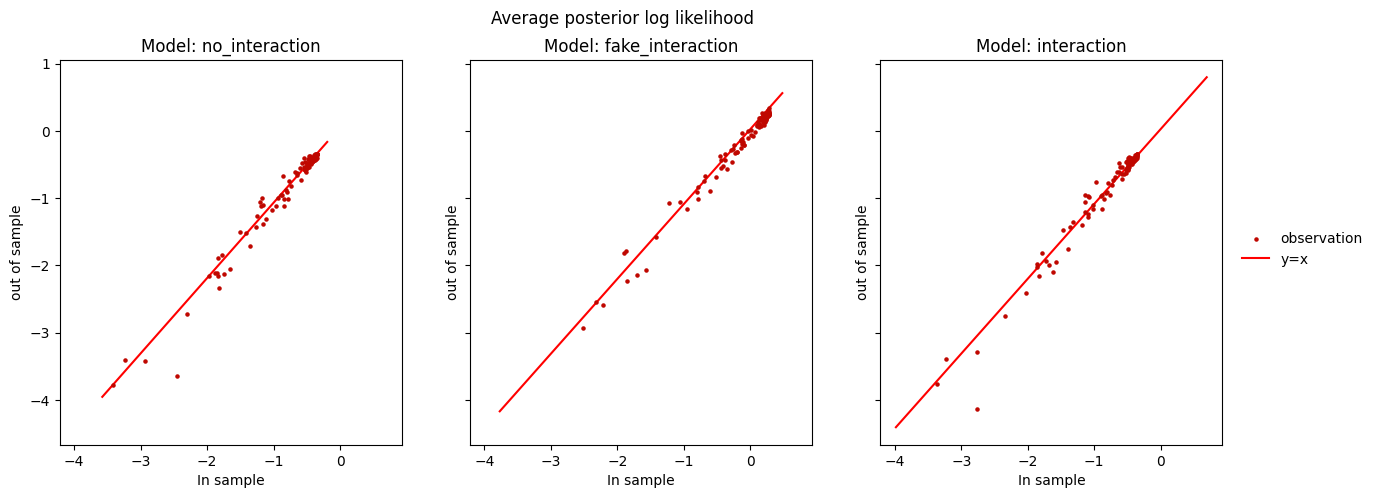

In [4]:
f, axes = plt.subplots(1, 3, figsize=[15, 5], sharex=True, sharey=True)

for ax, (name, idata) in zip(axes, idatas.items()):
    scatter = ax.scatter(
        idata.log_likelihood["llik"].mean(dim=["chain", "draw"]),
        idata.log_likelihood["llik_kfold"].mean(dim=["chain", "draw"]),
        s=5
    )
    line = ax.plot(ax.get_xlim(), ax.get_ylim(), color="red", zorder=0)
    text = ax.set(xlabel="In sample", ylabel="out of sample", title="Model: " + name)

suptitle = f.suptitle("Average posterior log likelihood")
legend = f.legend([scatter, line[0]], ["observation", "y=x"], frameon=False, loc="right")
f.savefig(os.path.join(PLOTS_DIR, "posterior_ll_comparison.png"))

Spot the model that was used to generate the "observed" data!

## Compare posterior predictive distributions

The last cell uses arviz to plot each posterior predictive distribution and saves the result to the `plots` directory.

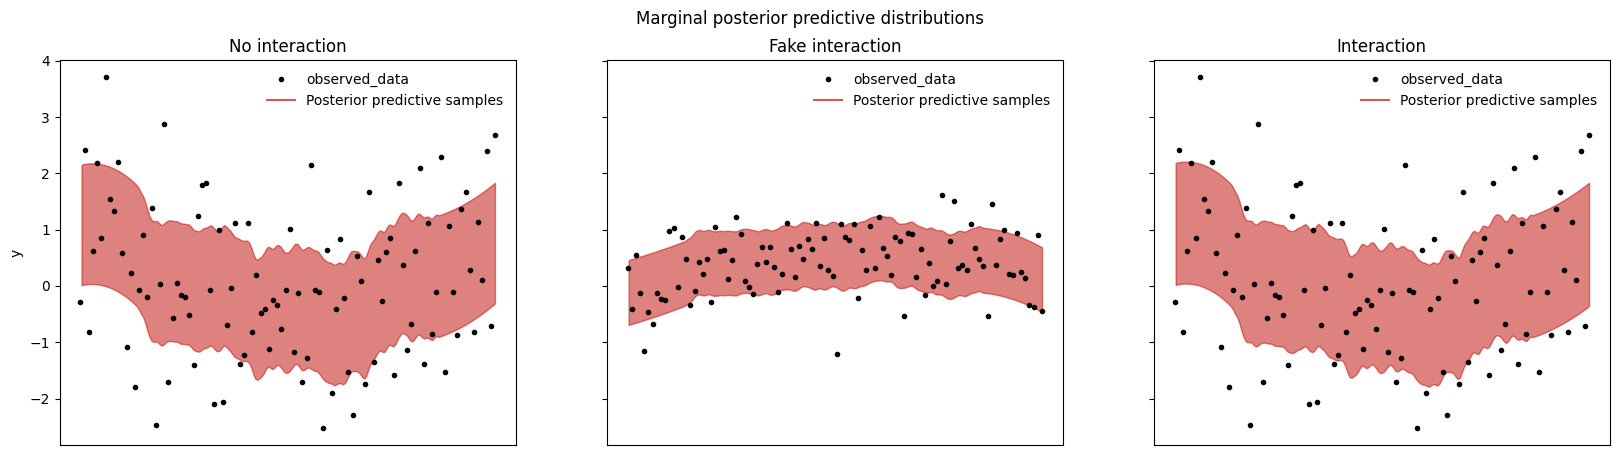

In [5]:
x = xarray.DataArray(np.linspace(0, 1, 100))
f, axes = plt.subplots(1, 3, figsize=[20, 5], sharey=True)
axes = axes.ravel()
for (name, idata), ax in zip(idatas.items(), axes):
        az.plot_lm(
            y="y",
            x=x,
            idata=idata,
            y_hat="yrep",
            axes=ax,
            kind_pp="hdi",
            y_kwargs={"markersize": 6, "color":"black"},
            grid=False
        )
        ax.legend(frameon=False)
        ax.set(title=name.replace("_", " ").capitalize(), ylabel="")
        ax.set_xticks([], [])
axes[0].set_ylabel("y")

suptitle = f.suptitle("Marginal posterior predictive distributions")
f.savefig(os.path.join(PLOTS_DIR, "posterior_predictive_comparison.png"))